In [1]:
%%capture
import numpy as np
import pandas as pd 

from tqdm import tqdm
import glob

!pip install torch-points-kernels

import torch
import torch.nn as nn

from torch_points_kernels import knn

In [2]:
from torch.utils.data import Dataset, DataLoader

import random

def read_pts(file):
    verts = np.genfromtxt(file)
    return verts

def read_seg(file):
    verts = np.genfromtxt(file, dtype= (int))
    return verts

def sub_sample(pcs, labels, k):    
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=k))
    pcs = res[:, 0:-1]
    labels = res[:, -1]
    labels -= 1
    return pcs, labels

class AirplanePartSegmenatationDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=False):
        
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        self.sample_size =  4000
        
        folders = glob.glob(root_dir + "/expert_verified/points_label")
        
        for folder in folders:
            img_labels = glob.glob(folder + "/*")
            self.labels += img_labels
            for img_label in img_labels:
                img_path = img_label.replace("/expert_verified/points_label", "/points")
                img_path = img_path.replace(".seg", ".pts")
                self.files.append(img_path) 
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pts_path = self.files[idx]
        label_path = self.labels[idx]
        
        with open(pts_path, 'r') as f:
            pts = read_pts(f)
        with open(label_path, 'r') as f:  
            label = read_seg(f)
                    
        pts, label = sub_sample(pts, label, self.sample_size)
        
        return {'points': np.array(pts, dtype="float32"), 'labels': label.astype(int)}

In [3]:
train_dataset = AirplanePartSegmenatationDataset("../input/airplane-part-segmenation/02691156")

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_data = torch.utils.data.Subset(train_dataset, indices[:2000])
val_data = torch.utils.data.Subset(train_dataset, indices[2000:])

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=32, shuffle=True, num_workers=0)

val_dataloader = torch.utils.data.DataLoader(
        val_data, batch_size=32, shuffle=False, num_workers=0)

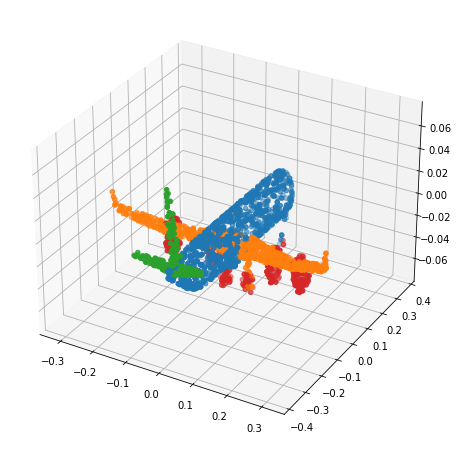

In [4]:
def plot_sample(sample_points, sample_labels, cal_preds=False, preds=None):
    sample_points = sample_points.numpy()
    
    if cal_preds:
        sample_labels = preds
    else:
        sample_labels = sample_labels.numpy()

    x = sample_points[:, 0]
    y = sample_points[:, 1]
    z = sample_points[:, 2]
    labels_color = []
    for label in sample_labels:
        if label == 0:
            labels_color.append('#1f77b4')
        elif label == 1:
            labels_color.append('#ff7f0e')
        elif label == 2:
            labels_color.append('#2ca02c')
        elif label == 3:
            labels_color.append('#d62728')
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(z,x, y, c=labels_color)
    plt.show()
    
sample = next(iter(train_dataloader))
plot_sample(sample['points'][0], sample['labels'][0])

In [5]:
import numpy as np
import torch

def accuracy(scores, labels):

    num_classes = scores.size(-2)

    predictions = torch.max(scores, dim=-2).indices

    accuracies = []

    accuracy_mask = predictions == labels
    for label in range(num_classes):
        label_mask = labels == label
        per_class_accuracy = (accuracy_mask & label_mask).float().sum()
        per_class_accuracy /= label_mask.float().sum()
        accuracies.append(per_class_accuracy.cpu().item())
        
    accuracies.append(accuracy_mask.float().mean().cpu().item())
    return accuracies

def iou(scores, labels):
    
    num_classes = scores.size(-2)

    predictions = torch.max(scores, dim=-2).indices

    ious = []

    for label in range(num_classes):
        pred_mask = predictions == label
        labels_mask = labels == label
        iou = (pred_mask & labels_mask).float().sum() / (pred_mask | labels_mask).float().sum()
        ious.append(iou.cpu().item())
    ious.append(np.nanmean(ious))
    return ious


def iou_loss(scores, labels):
    return 1-iou(scores, labels)

In [6]:
class SharedMLP(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=1,
        stride=1,
        transpose=False,
        padding_mode='zeros',
        bn=False,
        activation_fn=None
    ):
        super(SharedMLP, self).__init__()

        conv_fn = nn.ConvTranspose2d if transpose else nn.Conv2d

        self.conv = conv_fn(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding_mode=padding_mode
        )
        self.batch_norm = nn.BatchNorm2d(out_channels, eps=1e-6, momentum=0.99) if bn else None
        self.activation_fn = activation_fn

    def forward(self, input):
        r"""
            Forward pass of the network
            Parameters
            ----------
            input: torch.Tensor, shape (B, d_in, N, K)
            Returns
            -------
            torch.Tensor, shape (B, d_out, N, K)
        """
        x = self.conv(input)
        if self.batch_norm:
            x = self.batch_norm(x)
        if self.activation_fn:
            x = self.activation_fn(x)
        return x


class LocalSpatialEncoding(nn.Module):
    def __init__(self, d, num_neighbors, device):
        super(LocalSpatialEncoding, self).__init__()

        self.num_neighbors = num_neighbors
        self.mlp = SharedMLP(10, d, bn=True, activation_fn=nn.ReLU())

        self.device = device

    def forward(self, coords, features, knn_output):
        r"""
            Forward pass
            Parameters
            ----------
            coords: torch.Tensor, shape (B, N, 3)
                coordinates of the point cloud
            features: torch.Tensor, shape (B, d, N, 1)
                features of the point cloud
            neighbors: tuple
            Returns
            -------
            torch.Tensor, shape (B, 2*d, N, K)
        """
        # finding neighboring points
        idx, dist = knn_output
        B, N, K = idx.size()
        # idx(B, N, K), coords(B, N, 3)
        # neighbors[b, i, n, k] = coords[b, idx[b, n, k], i] = extended_coords[b, i, extended_idx[b, i, n, k], k]
        extended_idx = idx.unsqueeze(1).expand(B, 3, N, K)
        extended_coords = coords.transpose(-2,-1).unsqueeze(-1).expand(B, 3, N, K)
        neighbors = torch.gather(extended_coords, 2, extended_idx) # shape (B, 3, N, K)

        # relative point position encoding
        concat = torch.cat((
            extended_coords,
            neighbors,
            extended_coords - neighbors,
            dist.unsqueeze(-3)
        ), dim=-3).to(self.device)
        return torch.cat((
            self.mlp(concat),
            features.expand(B, -1, N, K)
        ), dim=-3)



class AttentivePooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentivePooling, self).__init__()

        self.score_fn = nn.Sequential(
            nn.Linear(in_channels, in_channels, bias=False),
            nn.Softmax(dim=-2)
        )
        self.mlp = SharedMLP(in_channels, out_channels, bn=True, activation_fn=nn.ReLU())

    def forward(self, x):
        r"""
            Forward pass
            Parameters
            ----------
            x: torch.Tensor, shape (B, d_in, N, K)
            Returns
            -------
            torch.Tensor, shape (B, d_out, N, 1)
        """
        # computing attention scores
        scores = self.score_fn(x.permute(0,2,3,1)).permute(0,3,1,2)

        # sum over the neighbors
        features = torch.sum(scores * x, dim=-1, keepdim=True) # shape (B, d_in, N, 1)

        return self.mlp(features)



class LocalFeatureAggregation(nn.Module):
    def __init__(self, d_in, d_out, num_neighbors, device):
        super(LocalFeatureAggregation, self).__init__()

        self.num_neighbors = num_neighbors

        self.mlp1 = SharedMLP(d_in, d_out//2, activation_fn=nn.LeakyReLU(0.2))
        self.mlp2 = SharedMLP(d_out, 2*d_out)
        self.shortcut = SharedMLP(d_in, 2*d_out, bn=True)

        self.lse1 = LocalSpatialEncoding(d_out//2, num_neighbors, device)
        self.lse2 = LocalSpatialEncoding(d_out//2, num_neighbors, device)

        self.pool1 = AttentivePooling(d_out, d_out//2)
        self.pool2 = AttentivePooling(d_out, d_out)

        self.lrelu = nn.LeakyReLU()

    def forward(self, coords, features):
        r"""
            Forward pass
            Parameters
            ----------
            coords: torch.Tensor, shape (B, N, 3)
                coordinates of the point cloud
            features: torch.Tensor, shape (B, d_in, N, 1)
                features of the point cloud
            Returns
            -------
            torch.Tensor, shape (B, 2*d_out, N, 1)
        """
        knn_output = knn(coords.cpu().contiguous(), coords.cpu().contiguous(), self.num_neighbors)

        x = self.mlp1(features)

        x = self.lse1(coords, x, knn_output)
        x = self.pool1(x)

        x = self.lse2(coords, x, knn_output)
        x = self.pool2(x)

        return self.lrelu(self.mlp2(x) + self.shortcut(features))



class RandLANet(nn.Module):
    def __init__(self, d_in, num_classes, num_neighbors=16, decimation=4, device=torch.device('cpu')):
        super(RandLANet, self).__init__()
        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_neighbors = num_neighbors
        self.decimation = decimation

        self.fc_start = nn.Linear(d_in, 8)
        self.bn_start = nn.Sequential(
            nn.BatchNorm2d(8, eps=1e-6, momentum=0.99),
            nn.LeakyReLU(0.2)
        )

        # encoding layers
        self.encoder = nn.ModuleList([
            LocalFeatureAggregation(8, 16, num_neighbors, device),
            LocalFeatureAggregation(32, 64, num_neighbors, device),
            LocalFeatureAggregation(128, 128, num_neighbors, device),
            LocalFeatureAggregation(256, 256, num_neighbors, device)
        ])

        self.mlp = SharedMLP(512, 512, activation_fn=nn.ReLU())

        # decoding layers
        decoder_kwargs = dict(
            transpose=True,
            bn=True,
            activation_fn=nn.ReLU()
        )
        self.decoder = nn.ModuleList([
            SharedMLP(1024, 256, **decoder_kwargs),
            SharedMLP(512, 128, **decoder_kwargs),
            SharedMLP(256, 32, **decoder_kwargs),
            SharedMLP(64, 8, **decoder_kwargs)
        ])

        # final semantic prediction
        self.fc_end = nn.Sequential(
            SharedMLP(8, 64, bn=True, activation_fn=nn.ReLU()),
            SharedMLP(64, 32, bn=True, activation_fn=nn.ReLU()),
            nn.Dropout(),
            SharedMLP(32, num_classes)
        )
        self.device = device

        self = self.to(device)

    def forward(self, input):
        r"""
            Forward pass
            Parameters
            ----------
            input: torch.Tensor, shape (B, N, d_in)
                input points
            Returns
            -------
            torch.Tensor, shape (B, num_classes, N)
                segmentation scores for each point
        """
        N = input.size(1)
        d = self.decimation

        coords = input[...,:3].clone().cpu()
        x = self.fc_start(input).transpose(-2,-1).unsqueeze(-1)
        x = self.bn_start(x) # shape (B, d, N, 1)

        decimation_ratio = 1

        # <<<<<<<<<< ENCODER
        x_stack = []

        permutation = torch.randperm(N)
        coords = coords[:,permutation]
        x = x[:,:,permutation]

        for lfa in self.encoder:
            # at iteration i, x.shape = (B, N//(d**i), d_in)
            x = lfa(coords[:,:N//decimation_ratio], x)
            x_stack.append(x.clone())
            decimation_ratio *= d
            x = x[:,:,:N//decimation_ratio]


        # # >>>>>>>>>> ENCODER

        x = self.mlp(x)

        # <<<<<<<<<< DECODER
        for mlp in self.decoder:
            neighbors, _ = knn(
                coords[:,:N//decimation_ratio].cpu().contiguous(), # original set
                coords[:,:d*N//decimation_ratio].cpu().contiguous(), # upsampled set
                1
            ) # shape (B, N, 1)
            neighbors = neighbors.to(self.device)

            extended_neighbors = neighbors.unsqueeze(1).expand(-1, x.size(1), -1, 1)

            x_neighbors = torch.gather(x, -2, extended_neighbors)

            x = torch.cat((x_neighbors, x_stack.pop()), dim=1)

            x = mlp(x)

            decimation_ratio //= d

        # >>>>>>>>>> DECODER
        # inverse permutation
        x = x[:,:,torch.argsort(permutation)]
        scores = self.fc_end(x)
        return scores.squeeze(-1)

#ref: https://github.com/aRI0U/RandLA-Net-pytorch/

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
randlanet = RandLANet(
        d_in=3,
        num_classes=4,
        device=device
    )

optimizer = torch.optim.Adam(randlanet.parameters(), lr=0.005)

In [11]:
def train():
    
    metrics = {'train_loss': [],
               'train_accuracy': [],
               'train_iou': [],
               'val_iou': [],
               'val_accuracy': []}
    
    criterion =  nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    
    for epoch in range(20):
        print("Epoch ", epoch+1, ": ")

        randlanet.train()

        losses = []
        accuracies = []
        ious = []

        for data in tqdm(train_dataloader): 
            points = data['points'].to(device)
            labels = data['labels'].to(device)
            labels = labels.long()
            optimizer.zero_grad()

            scores = randlanet(points)

            #logp = torch.distributions.utils.probs_to_logits(scores, is_binary=False)
            
            loss = criterion(scores, labels)

            loss.backward()

            optimizer.step()

            losses.append(loss.cpu().item())
            accuracies.append(accuracy(scores, labels))
            ious.append(iou(scores, labels))

        scheduler.step()

        accs = np.nanmean(np.array(accuracies), axis=0)
        ious = np.nanmean(np.array(ious), axis=0)
        
        print("Training Loss: ", np.mean(losses))
        print("Training Accuracy: ", np.mean(accs))
        print("Training IOU: ", np.mean(ious))
        
        metrics['train_loss'].append(np.mean(losses))
        metrics['train_accuracy'].append(np.mean(accs))
        metrics['train_iou'].append(np.mean(ious))
        
        accuracies = []
        ious = []
        
        for data in val_dataloader: 
            points = data['points'].to(device)
            labels = data['labels'].to(device)
            labels = labels.long()
            
            scores = randlanet(points)

            accuracies.append(accuracy(scores, labels))
            ious.append(iou(scores, labels))
        
        val_accs = np.nanmean(np.array(accuracies), axis=0)
        val_ious = np.nanmean(np.array(ious), axis=0)
        
        print("Validation Accuracy: ", np.mean(val_accs))
        print("Validation IOU: ", np.mean(val_ious))
        
        metrics['val_accuracy'].append(np.mean(val_accs))
        metrics['val_iou'].append(np.mean(val_ious))
        
        
    torch.save(randlanet.state_dict(), "./randla_model")
    
    return metrics

In [12]:
metrics = train()

Epoch  1 : 


100%|██████████| 63/63 [02:28<00:00,  2.35s/it]


Training Loss:  0.5280549407951416
Training Accuracy:  0.7747296354127309
Training IOU:  0.6487159202437078
Validation Accuracy:  0.8364025267687711
Validation IOU:  0.7185369225388223
Epoch  2 : 


100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


Training Loss:  0.3434939389190977
Training Accuracy:  0.8525116644208394
Training IOU:  0.7466412759016431
Validation Accuracy:  0.8549986828457226
Validation IOU:  0.7518171776424754
Epoch  3 : 


100%|██████████| 63/63 [01:49<00:00,  1.75s/it]


Training Loss:  0.3096328770357465
Training Accuracy:  0.8718784765591696
Training IOU:  0.7717951117526918
Validation Accuracy:  0.86587236198512
Validation IOU:  0.7681783979589288
Epoch  4 : 


100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


Training Loss:  0.2907348991859527
Training Accuracy:  0.8803070747663104
Training IOU:  0.7840141412757692
Validation Accuracy:  0.8709057363596828
Validation IOU:  0.7786120704629205
Epoch  5 : 


100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


Training Loss:  0.279430367643871
Training Accuracy:  0.8849469962574187
Training IOU:  0.7918717960516612
Validation Accuracy:  0.8791835947470231
Validation IOU:  0.7840340333906088
Epoch  6 : 


100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


Training Loss:  0.2730024007577745
Training Accuracy:  0.8872054544706194
Training IOU:  0.7962452355358336
Validation Accuracy:  0.8846432409503244
Validation IOU:  0.7876652011817151
Epoch  7 : 


100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


Training Loss:  0.26930324567688835
Training Accuracy:  0.8890957011116875
Training IOU:  0.7981024945066089
Validation Accuracy:  0.8791014936837284
Validation IOU:  0.7913189692930742
Epoch  8 : 


100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


Training Loss:  0.26140115161736804
Training Accuracy:  0.8918224486093672
Training IOU:  0.8039344953639167
Validation Accuracy:  0.8821908116340638
Validation IOU:  0.7902473780241879
Epoch  9 : 


100%|██████████| 63/63 [01:47<00:00,  1.70s/it]


Training Loss:  0.2570786726853204
Training Accuracy:  0.8943609807226395
Training IOU:  0.8079915484265676
Validation Accuracy:  0.8857506280595606
Validation IOU:  0.7916151705113325
Epoch  10 : 


100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


Training Loss:  0.2556826801054061
Training Accuracy:  0.8948653546590654
Training IOU:  0.8087936235325678
Validation Accuracy:  0.8898093581199646
Validation IOU:  0.8003464673053134
Epoch  11 : 


100%|██████████| 63/63 [01:48<00:00,  1.71s/it]


Training Loss:  0.2521634513423556
Training Accuracy:  0.8957566329411097
Training IOU:  0.8098354583221768
Validation Accuracy:  0.8930563975464214
Validation IOU:  0.8033765635707162
Epoch  12 : 


100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


Training Loss:  0.2467148214105576
Training Accuracy:  0.8985916839705574
Training IOU:  0.8143859891191362
Validation Accuracy:  0.8853569805622101
Validation IOU:  0.8002197606997056
Epoch  13 : 


100%|██████████| 63/63 [01:48<00:00,  1.73s/it]


Training Loss:  0.24577015307214525
Training Accuracy:  0.8989357575537665
Training IOU:  0.8152037676837709
Validation Accuracy:  0.8886579345573079
Validation IOU:  0.8047129010612315
Epoch  14 : 


100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


Training Loss:  0.24131465927949028
Training Accuracy:  0.9000237807394965
Training IOU:  0.817945565969225
Validation Accuracy:  0.896467032215812
Validation IOU:  0.8086468292908237
Epoch  15 : 


100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


Training Loss:  0.23984536504934703
Training Accuracy:  0.9004974590407476
Training IOU:  0.8190214078104685
Validation Accuracy:  0.8953505803238262
Validation IOU:  0.8067523430694233
Epoch  16 : 


100%|██████████| 63/63 [01:50<00:00,  1.75s/it]


Training Loss:  0.24019095183364927
Training Accuracy:  0.9008484331388322
Training IOU:  0.819306244216268
Validation Accuracy:  0.8916372738101266
Validation IOU:  0.8082975216887215
Epoch  17 : 


100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


Training Loss:  0.2365000160440566
Training Accuracy:  0.9028726562621102
Training IOU:  0.8224260192068795
Validation Accuracy:  0.8874682881615378
Validation IOU:  0.8069657182151622
Epoch  18 : 


100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


Training Loss:  0.23699270141503168
Training Accuracy:  0.9024456578587727
Training IOU:  0.8224404896535571
Validation Accuracy:  0.8906919858672401
Validation IOU:  0.8086542439731683
Epoch  19 : 


100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


Training Loss:  0.2328760399231835
Training Accuracy:  0.9040596044252791
Training IOU:  0.8242211561827432
Validation Accuracy:  0.8959101850336249
Validation IOU:  0.81003606996753
Epoch  20 : 


100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


Training Loss:  0.23200403272159517
Training Accuracy:  0.904097537010435
Training IOU:  0.8248224386147089
Validation Accuracy:  0.8964368901469489
Validation IOU:  0.8128814141858707


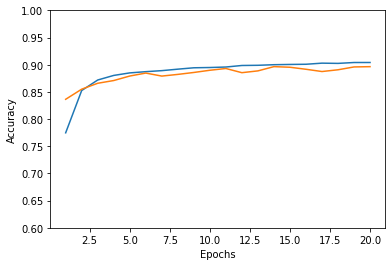

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(metrics['train_accuracy']) + 1), metrics['train_accuracy'])
plt.plot(range(1, len(metrics['val_accuracy']) + 1), metrics['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1)
plt.show()

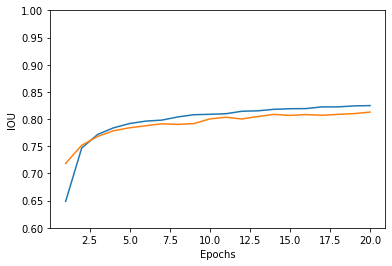

In [17]:
plt.plot(range(1, len(metrics['train_iou']) + 1), metrics['train_iou'])
plt.plot(range(1, len(metrics['val_iou']) + 1), metrics['val_iou'])
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.ylim(0.6, 1)
plt.show()